In [26]:
from poplar.distributions import VariableLimitsPowerLaw, FixedLimitsPowerLaw, UniformDistribution
from poplar.nn.networks import LinearModel
from poplar.nn.training import train, train_test_split
from poplar.nn.rescaling import ZScoreRescaler
from poplar.nn.plot import loss_plot
from poplar.selection import selection_function_from_optimal_snr, matched_filter_snr_from_optimal_snr
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm

device = "cuda:1"
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [12,7]

# End-to-end usage example

In this example, we're going to learn an analytic SNR function and use it to model selection effects for a population of gravitational 
wave signals from compact binary coalescences. 

In reality, the SNR function is not analytic but our approach would be valid nonetheless.

### Learning signal detectability

Firstly, let's define an SNR function. We're going to focus on a few parameters: the masses $(m_1, m_2)$ of the compact objects, the luminosity distance to the binary $d_L$ (in some arbitrary units) and a trigonometric function of two "sky position angles" $(\alpha, \delta)$. 
We define the optimal SNR $\rho$ as
$$ \rho = \frac{1}{d_L} \mathcal{M_c}^{2.2} f(\alpha, \delta)$$
where $\mathcal{M_c}$ is the chirp mass of the binary, defined as 
$$ \mathcal{M_c} = \frac{(m_1m_2)^{3/5}}{(m_1 + m_2)^{1/5}} $$
and
$$ f(\alpha, \delta) = -(1 + \cos^2(2\alpha/3) - \sin^2(5\delta/3))\cos(5\alpha/6)\sin(4\delta/3)$$

Let's define these functions and visualise the form of $f$:

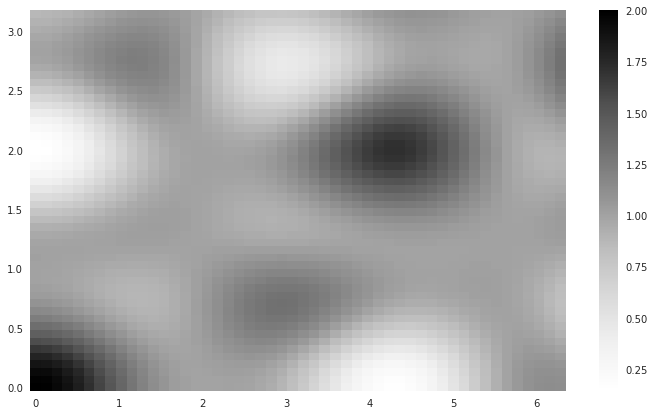

In [29]:
def dummy_antenna_pattern(a, d):
    return 1 + (np.cos(2*a/3)**2 - np.sin(5*d/3)**2)*np.cos(5*a/6)*np.cos(4*d/3)

def mchirp(m1, m2):
    return (m1 * m2)**(3/5) / (m1 + m2)**(1/5)

def snr(m1, m2, dL, alpha, delta):
    return 1/dL * mchirp(m1, m2)**2.2 * dummy_antenna_pattern(alpha, delta)

av, dv = np.meshgrid(np.linspace(0,2*np.pi), np.linspace(0, np.pi))
Z = dummy_antenna_pattern(av, dv)
plt.pcolormesh(av, dv, Z)
plt.colorbar()
plt.show()

We're going to consider masses in the range [1, 100] $M_\odot$, angles in the range $[0, 2 \pi]$ and $[0, \pi]$ for $\alpha$ and $\delta$ respectively and $d_L$ in the range $[0.01, 1]$ (in some arbitrary units). 

Let's generate a dataset of SNRs in this prior range, and our neural network to be trained on these SNRs. As SNR scales inversely with luminosity distance (which is obviously true for our analytic example, but is also true in general), we can factorise this out and train on the remaining parameters. To ensure that the network output is positive definite, we train on $\log(\rho)$.

In [62]:
n_train = int(2e5)  # number of training examples

# sample from our priors
m1 = np.random.uniform(1, 100, n_train)
m2 = np.random.uniform(1, 100, n_train)
dL = np.random.uniform(0.01, 1, n_train)
alpha = np.random.uniform(0, 2*np.pi, n_train)
delta = np.random.uniform(0, np.pi, n_train)

true_snrs = snr(m1, m2, dL , alpha, delta)
xdata = torch.as_tensor(np.vstack((m1, m2, alpha, delta)).T, device=device).float()
ydata = torch.as_tensor(true_snrs * dL, device=device).float()

In [63]:
# define a rescaler, which handles the scaling of input data to facilitate training
rescaler = ZScoreRescaler(xdata, ydata, yfunctions=[torch.log, torch.exp])

In [64]:
# define the neural network
model = LinearModel(
    in_features=4,
    out_features=1,
    neurons=[128, 128, 128, 128],
    activation=torch.nn.SiLU,
    rescaler=rescaler
)   

model.set_device(device)

In [65]:
train_up_to = int(0.9 * n_train)
xtrain, xtest, ytrain, ytest = train_test_split([xdata, ydata], 0.9)
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)

In [66]:
train(
    model, 
    data=[xtrain, ytrain, xtest, ytest], 
    n_epochs=10000, 
    n_batches=1, 
    loss_function=torch.nn.L1Loss(),
    optimiser=optimiser,
    update_every=1000,
    verbose=True,
)

Epoch: 9999 | Train loss: 1.778e-02 | Test loss: 1.853e-02 (Lowest: 1.814e-02)
Training complete - saving.


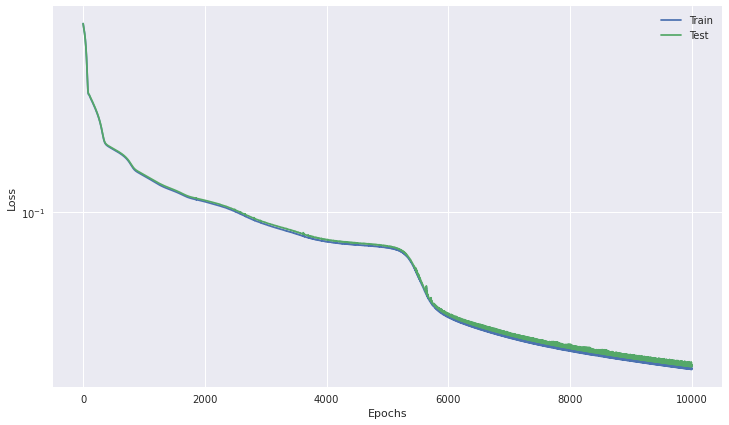

In [67]:
_ = loss_plot(model.loss_curves[0], model.loss_curves[1])

The model has trained well (but could be improved with some iterative adjustment of training settings). 

We can plot a histogram of the performance of the network on the validation set to see how well it has trained.

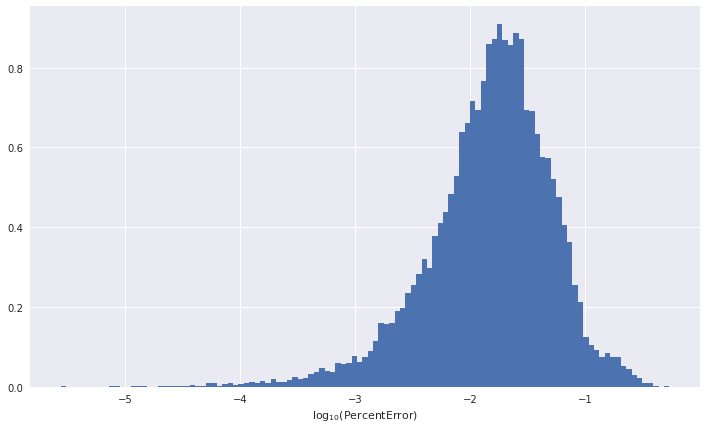

In [68]:
ypred = model.run_on_dataset(xtest)

plt.hist(np.log10(abs((1 - ypred/ytest).cpu().numpy())), bins='auto', density=True)
plt.xlabel(r'$\log_{10}(\mathrm{Percent Error})$')
plt.show()

### Estimating the Selection Function

We're now ready to use this model to predict the detectability of a distribution of these events. We'll consider a distribution where we parameterise the mass distributions as powerlaws with slope $\lambda = -2$ and limits $[1, 100]M_\odot$. Events will be distributed uniformly on the sky, and luminosity distance will scale with a power law of slope $\lambda = -3$ (as one would expect for a volumetric distribution).

Detectability is evaluated by comparing the optimal SNR of each event with a pre-defined threshold $\rho_t$. The fraction of the population that is detectable (known as the selection function) is $$ \alpha = 1 - \Phi_{\chi^2}(\rho| k=N_\mathrm{det}, n=\rho_t)$$ where $\Phi_{\chi^2}$ is the CDF of the non-central chi-square distribution with degrees of freedom $k$ and non-centrality parameter $n$. $N_\mathrm{det}$ is the number of detectors in the observing network.

In this somewhat arbitrary case, we'll use a threshold of $20$ and assume a network of two detectors was used to observe all of the events.

In [69]:
# set up distributions
distributions = {
    "m1": VariableLimitsPowerLaw([1,100], device=device),
    "m2": FixedLimitsPowerLaw([1,100], device=device),
    "dL": FixedLimitsPowerLaw([0.01,1], device=device),
    "alpha": UniformDistribution([0, 2*np.pi], device=device),
    "delta": UniformDistribution([0, np.pi], device=device)
}

#Population distribution class for ease of evaluating PDF and drawing points
class PopulationDistribution:
    def __init__(self, distributions, data) -> None:
        self.distributions = distributions
        self.data = data

    def pdf(self, x):
        m1params = x['m1']
        return self.distributions['m1'].pdf(self.data['m1'], **m1params)

    def draw_samples(self, x, size):
        out = {}
        for key in self.distributions.keys():
            out[key] = self.distributions[key].draw_samples(**x[key], size=size)
        return out

popdist = PopulationDistribution(distributions=distributions, data=None)

In [70]:
true_x = {
    "m1": {"lam": -2, "xlow": 1, "xhigh": 100},
    "m2": {"lam": -2},
    "dL": {"lam": 3},
    "alpha": {},
    "delta": {},
}

catalogue = popdist.draw_samples(true_x, size=int(1e5))

In [71]:
catalogue_snrs = model.run_on_dataset(torch.vstack([catalogue['m1'],catalogue['m2'],catalogue['alpha'],catalogue['delta']]).T, luminosity_distances=catalogue['dL'])
numpy_catalogue = {cat_label: cat_samples.cpu().numpy() for cat_label, cat_samples in catalogue.items()}
true_snrs = snr(**numpy_catalogue)

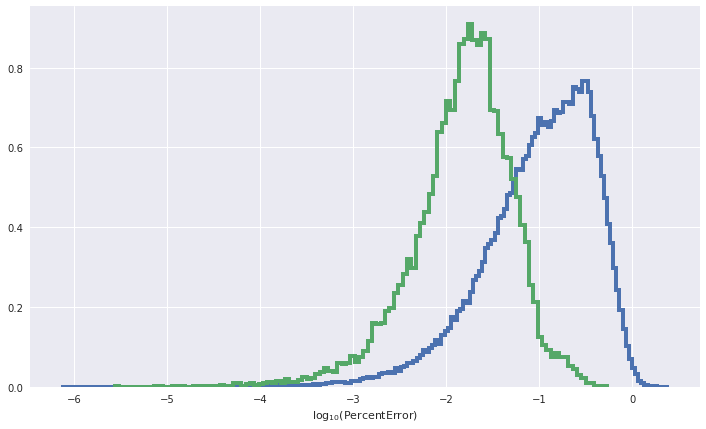

In [72]:
plt.hist(np.log10(abs((1 - catalogue_snrs.cpu().numpy()/true_snrs))), bins='auto', density=True, histtype='step', lw=4)
plt.hist(np.log10(abs((1 - ypred/ytest).cpu().numpy())), bins='auto', density=True, histtype='step', lw=4)
plt.xlabel(r'$\log_{10}(\mathrm{Percent Error})$')
plt.show()

In [73]:
predicted_alpha = selection_function_from_optimal_snr(catalogue_snrs, 20, number_of_detectors=2)
true_alpha = selection_function_from_optimal_snr(torch.as_tensor(true_snrs, device=device), 20, number_of_detectors=2)

print(predicted_alpha.item(), true_alpha.item())

0.20733422802864038 0.2004947033716055


We are capable of estimating the selection function using our SNR network in this way, but we can make some further improvements by introducing a second network into the mix: one that is trained on _selection function estimates_. The training dataset for this network would be expensive to produce for a realistic scenario, but our SNR network allows us to bypass this cost and produce the dataset quickly.

Let's illustrate this with a one-dimensional example, where we investigate how varying $\lambda_{m_1}$ affects the population detectability.

In [74]:
lambda_m1s = np.random.uniform(-3, 2, int(1e3))
selection_functions = []
true_selection_functions = []

for lam_m1 in tqdm.tqdm(lambda_m1s):
    true_x['m1']['lam'] = torch.as_tensor(lam_m1).float()
    catalogue = popdist.draw_samples(true_x, size=int(1e5))
    numpy_catalogue = {cat_label: cat_samples.cpu().numpy() for cat_label, cat_samples in catalogue.items()}
    true_snrs = snr(**numpy_catalogue)
    catalogue_snrs = model.run_on_dataset(torch.vstack([catalogue['m1'],catalogue['m2'],catalogue['alpha'],catalogue['delta']]).T, luminosity_distances=catalogue['dL'])
    selection_functions.append(selection_function_from_optimal_snr(catalogue_snrs, 20, number_of_detectors=2))
    true_selection_functions.append(selection_function_from_optimal_snr(true_snrs, 20, number_of_detectors=2))

100%|██████████| 1000/1000 [02:25<00:00,  6.86it/s]


In [75]:
sel_xdata = torch.as_tensor(lambda_m1s, device=device)[:,None].float()
sel_ydata = torch.as_tensor(selection_functions, device=device).float()

rescaler2 = ZScoreRescaler(sel_xdata, sel_ydata)

selection_function_model = LinearModel(
    1,
    1,
    [128, 128, 128],
    activation=torch.nn.SiLU,
    rescaler=rescaler2
)

selection_function_model.set_device(device)

sel_xtrain, sel_xtest, sel_ytrain, sel_ytest = train_test_split([sel_xdata, sel_ydata], 0.9)

train(
    selection_function_model, 
    [sel_xtrain, sel_ytrain, sel_xtest, sel_ytest], 
    n_epochs=5000, 
    n_batches=1,
    optimiser = torch.optim.Adam(selection_function_model.parameters(), lr=1e-4),
    loss_function=torch.nn.L1Loss(),
    update_every=1000,
    verbose=True)

Epoch: 4999 | Train loss: 2.932e-03 | Test loss: 2.928e-03 (Lowest: 2.617e-03)
Training complete - saving.


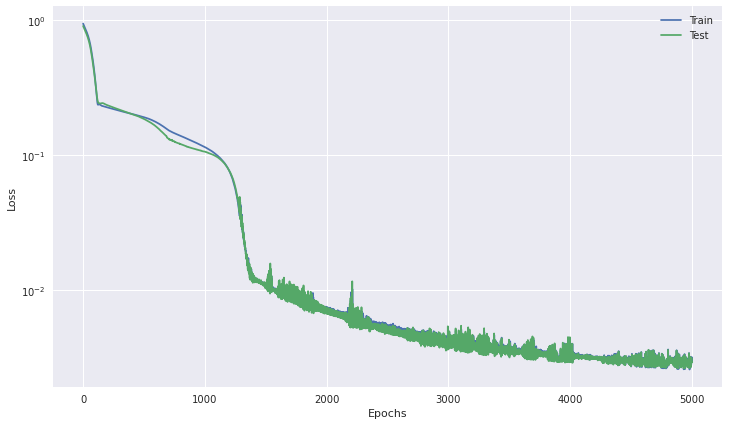

In [76]:
_ = loss_plot(selection_function_model.loss_curves[0], selection_function_model.loss_curves[1])

In [77]:
lambda_m1_testvec = torch.linspace(-3, 2, int(1e3), device=device)[:,None]
sel_pred = selection_function_model.run_on_dataset(lambda_m1_testvec)

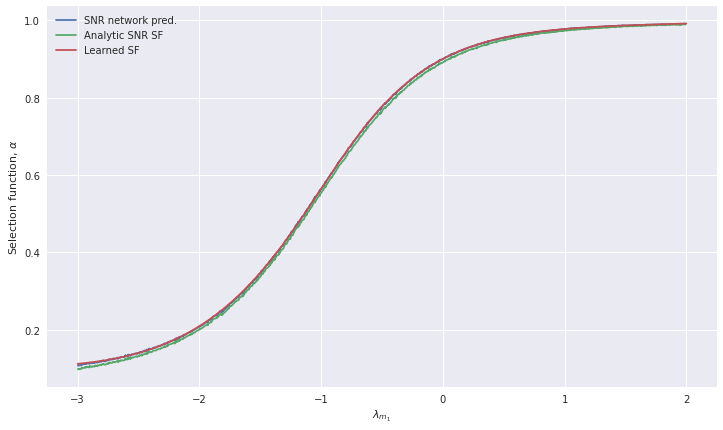

In [78]:
sort_inds = np.argsort(lambda_m1s)
plt.plot(lambda_m1s[sort_inds], torch.as_tensor(selection_functions).numpy()[sort_inds], label='SNR network pred.')
plt.plot(lambda_m1s[sort_inds], np.array(true_selection_functions)[sort_inds], label='Analytic SNR SF')
plt.plot(lambda_m1_testvec.cpu().numpy(), sel_pred.cpu().numpy(), label='Learned SF')
plt.legend()
plt.ylabel(r'Selection function, $\alpha$')
plt.xlabel(r'$\lambda_{m_1}$')
plt.legend()
plt.show()

This trained selection function network is now ready to be used in population inference to deliver rapid estimates of the selection function at low additional computational cost.

We can demonstrate the effectiveness of our interpolator with a population inference example.

First, we generate a catalogue based on a set of true parameters and threshold it for detectability.

In [79]:
n_events = 1000  # total number of events
true_x = {
    "m1": {"lam": -1.5, "xlow": 1, "xhigh": 100},
    "m2": {"lam": -2},
    "dL": {"lam": 3},
    "alpha": {},
    "delta": {},
}
catalogue = popdist.draw_samples(true_x, size=n_events)
catalogue = {n: d.cpu().numpy() for n, d in catalogue.items()}
optimal_snrs = snr(**catalogue)
noise_realised_snrs = matched_filter_snr_from_optimal_snr(optimal_snrs, number_of_detectors=2)
kept_catalogue_indices = np.where(noise_realised_snrs > 20)[0]
kept_catalogue = {n: d[kept_catalogue_indices] for n, d in catalogue.items()}
popdist.data = kept_catalogue  # update the catalogue with our detections
Ndet = len(kept_catalogue_indices)

f"Number of detected events: {Ndet}, NN selection function predicts ~{int(n_events*selection_function_model.run_on_dataset(true_x['m1']['lam']))}"

'Number of detected events: 335, NN selection function predicts ~347'

Now, we define our hierarchical likelihood. We ignore measurement uncertainty here and assume wide, flat priors.

In [80]:
def hierarchical_likelihood(hyperparameters, Ndet, selection=False):
    numerator = np.sum(np.log(popdist.pdf(hyperparameters).cpu().numpy()), axis=-1)  # sum the log-probabilities
    denominator = Ndet*np.log(selection_function_model.run_on_dataset(hyperparameters['m1']['lam']).cpu().numpy()) if selection else 0
    return numerator - denominator

In [81]:
lambda_m1_grid = torch.linspace(-2, -0.3, int(1e4), device=device)[:,None]
ones = torch.ones_like(lambda_m1_grid, device=device)
trial_x = {
    "m1": {"lam": lambda_m1_grid, "xlow": ones, "xhigh": 100*ones},
    "m2": {"lam": -2*ones},
    "dL": {"lam": 3*ones},
    "alpha": {},
    "delta": {},
}

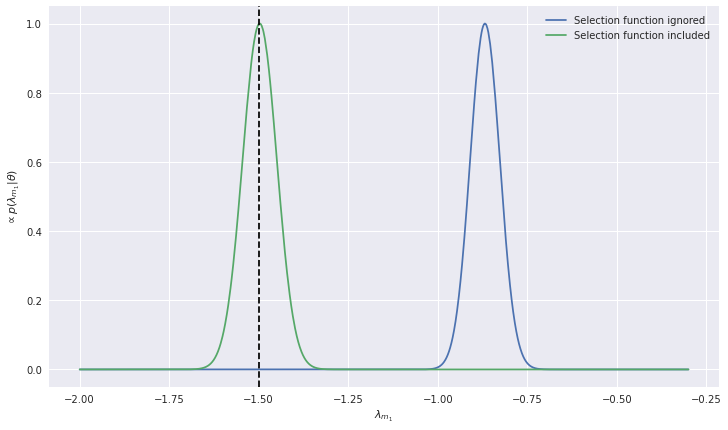

In [82]:
no_sf_logposterior = hierarchical_likelihood(trial_x, Ndet, selection=False)
sf_logposterior = hierarchical_likelihood(trial_x, Ndet, selection=True)

plt.plot(lambda_m1_grid.cpu().numpy(), np.exp(no_sf_logposterior - no_sf_logposterior.max()), label='Selection function ignored')
plt.plot(lambda_m1_grid.cpu().numpy(), np.exp(sf_logposterior - sf_logposterior.max()), label='Selection function included')
plt.axvline(true_x['m1']['lam'], c='k', ls='--')
plt.ylabel(r'$\propto p(\lambda_{m_1} | \theta)$')
plt.xlabel(r'$\lambda_{m_1}$')
plt.legend()
plt.show()

This demonstrates the importance of including the selection function in population inference, and that we can model the selection function from start to finish with neural networks.